In [22]:
import warnings; warnings.filterwarnings('ignore')

import itertools
import numpy as np
from pprint import pprint

from collections import defaultdict

import gymnasium as gym
from gridworld.envs import SiblingGridWorldEnv
from gymnasium.envs.registration import register
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm

import random
import matplotlib
import matplotlib.pyplot as plt
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [7]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
plt.rcParams.update(params)
np.set_printoptions(precision=3, suppress=True)

In [8]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [9]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

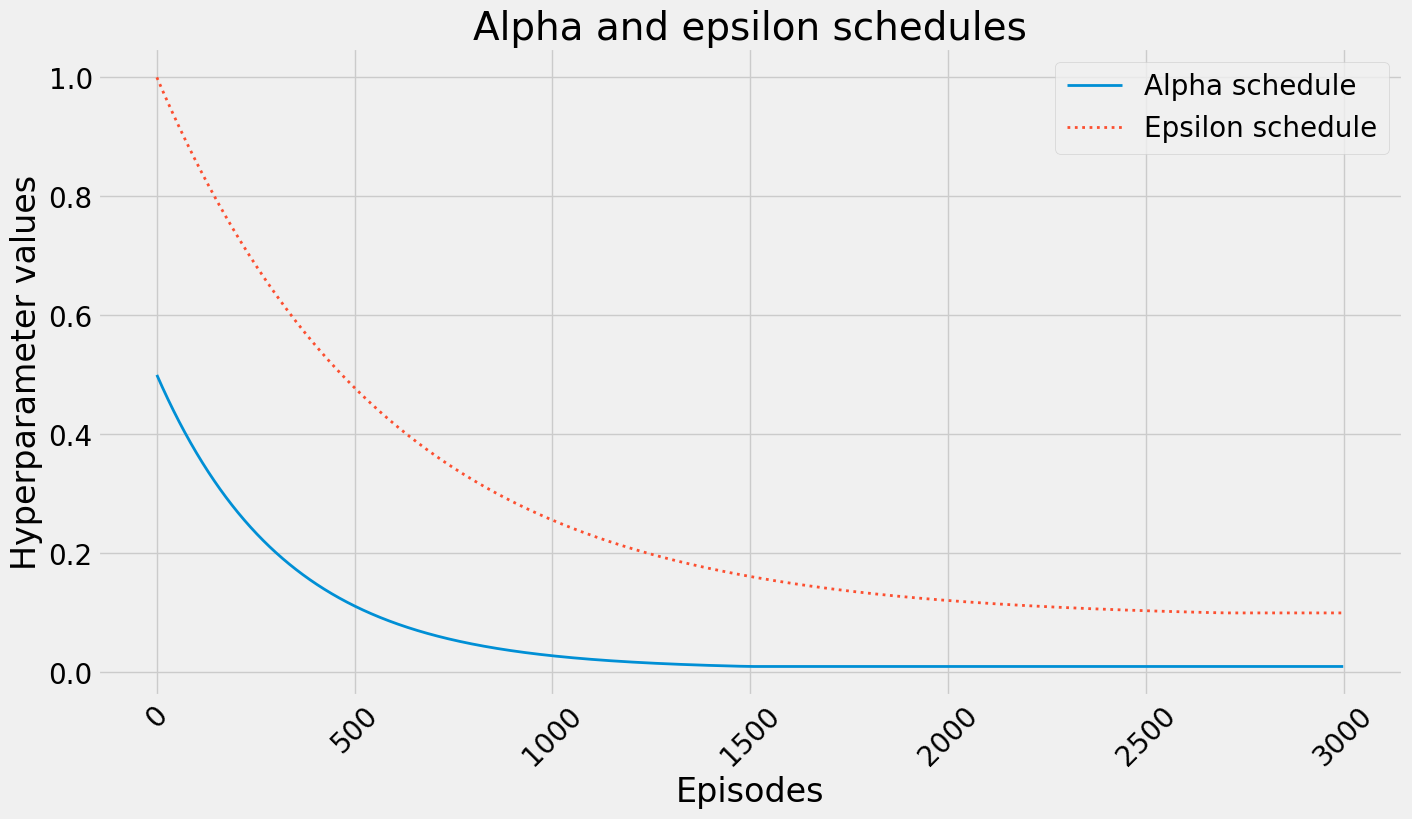

In [11]:
n_episodes = 3000

plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes),
         '-', linewidth=2, 
         label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes), 
         ':', linewidth=2, 
         label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()

In [ ]:
def q_learning(env, 
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(init_alpha, 
                           min_alpha, 
                           alpha_decay_ratio, 
                           n_episodes)
    epsilons = decay_schedule(init_epsilon, 
                              min_epsilon, 
                              epsilon_decay_ratio, 
                              n_episodes)
    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            state = next_state

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [6]:
def sibling():
    env = SiblingGridWorldEnv()
#     env = RelativePositionenv)
    return env

register(
    id='SiblingGridWorld-v0',
    entry_point=sibling,
    max_episode_steps=300,
)

env = gym.make('SiblingGridWorld-v0')
print(env.reset())

(array([1, 3, 7]), {'distance': 4.0})


In [20]:
env.observation_space.is_bounded()

True

In [24]:
defaultdict(lambda: np.zeros(env.action_space.n))

defaultdict(<function __main__.<lambda>()>, {})

In [26]:
env.action_space.n

AttributeError: 'Box' object has no attribute 'n'